In [31]:
from camo_worms_utils import *

from itertools import product

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


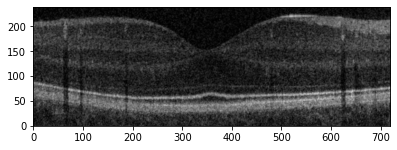

In [32]:
# Read, crop and display image and stats

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Initialise clew of 40 and draw

GENERATIONS = 5000 # Actually should be Iterations for an SSGA
POPULATION = 250
PERCENT = 10 # Not used for SSGA

#clew = initialise_clew(40, image.shape, (40, 30, 1))
clew = initialise_clew(POPULATION, image.shape, (40, 30, 1))


#drawing = Drawing(image)
#drawing.add_worms(clew)
#drawing.show()

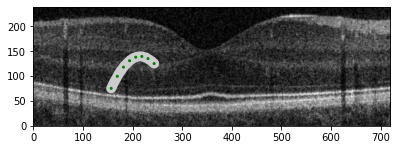

In [33]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
#drawing.add_dots(worm.control_points(),color='orange')
#drawing.add_dots((200,100), color='blue')



drawing.show(save='bezier.png')

# Helper Methods

### Size Calcs
calc_size and calc_ideal_width create big worms which is unwanted.
calc_too_small produced the best results

In [34]:
def calc_size(worm, image):
    # --- Size ---
        # Big Worms to counteract 1 pixel worms being highest score
        size = worm.approx_length()*worm.width / image.shape[1] # size as a percentage of image width
        return size

def calc_ideal_width(worm):
    # lets just say we want worms to be around 5 px wide
    # scale so that 5px => low score, lower or higher width => high score
    ideal_width = 10
    dist_from_ideal = np.abs(worm.width - ideal_width)

    return dist_from_ideal

def calc_too_small(worm):
    # What if we just want bigger than a certain size
    min_width = 3
    min_length = 4

    # Big score: (4-20))/4  = -4, maxed to 0
    # Same Size: (4-4)/4    = 0
    # Small score: (4-1)/4  = 0.75
    wid_diff = (min_width - worm.width)/min_width
    wid_diff = max(0, wid_diff) # Remove negative vals
    
    len_diff = (min_length - worm.approx_length() )/min_length
    len_diff = max(0, len_diff) # Remove negative vals


    #print("Testing too small. Worm wid*len: {wid}*{len}\n    wid_diff={w_d}, len_diff={l_d}".format(
    #     len=round(worm.approx_length(),2),
    #     wid=round(worm.width,2),
    #     w_d=round(wid_diff,2),
    #     l_d=round(len_diff,2)
    #    )
    #)

    combined = wid_diff*0.5 + len_diff*0.5 # scale to be between 0 and 1, combined

    return combined





def off_screen_penalty(worm, image):
    off_screen_penalty = 0
    xmin, xmax = [0, image.shape[0]]
    ymin, ymax = [0, image.shape[1]]
    if(worm.x > xmin
        and worm.x < xmax
        and worm.y > ymin
        and worm.y < ymax ):
        off_screen_penalty = 1
    return off_screen_penalty

### Distance Calcs
count_overlaps():
This method counts overlaps with other worms. It was useful to push worms apart without forcing large spaces.


average_distance():
This method counts the euclidian distance to each other worm in the clew, then averages it. It generally pushed worms to the edges of the image, as it has no maximum value.

In [35]:
def count_overlaps(worm, clew):
    # count-based - get proportion of other worms "touching" this worm
    # define "touching" as dist to other point is less than this.width+other.width
    count = 0
    for i in range(len(clew)):
        # base off of three intermediate points
        # i.e. add one to count if any points are too close
        points_worm = worm.intermediate_points()
        points_other = clew[i].intermediate_points()
        
        combos = list(product(points_worm, points_other))

        for point_worm, point_other in combos:
            euclid_dist = np.linalg.norm(
                np.array(point_worm)-np.array(point_other)
            )
            # print(f"Points {point_worm}, {point_other}")
            # print(f"Widths {worm.width}, {clew[i].width}")
            # print(f"Dist {euclid_dist}\n")
            if euclid_dist < worm.width + clew[i].width:
                # theyre touching
                count += 1
                break
    proportion = count/(len(clew)-1)
    # print(f"Count: {count}, Proportion: {proportion}")
    return proportion




def average_distance(worm, clew):
    dists = []

    for i in range(len(clew)):
        # print("Distance: ({x1},{y1}) to ({x2},{y2})".format(x1=worm.x, y1=worm.y, x2=clew[i].x, y2=clew[i].y))
        euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
        # print(f"Worm centre ({worm.x}, {worm.y})")
        # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
        # print(f"Dist: {euclid_dist}")
        #print("euclid_dist:{}".format(euclid_dist))
        if(euclid_dist != 0):
            dists.append(euclid_dist)

        # don't bother checking if it's the same worm. It will just be a distance of 0.

    if(dists):  # not empty
        avg_dist = np.mean(dists)
    else:
        avg_dist = 0
        print("Nothing in list. Len={}".format(len(clew)))

    return avg_dist

### Colour Functions
average_colour_diff: 
Fast results, but only calculated along the centerline, and did not account for the width of the worm.

colours_under():
This gave the best colour results by calcing colour at every pixel within a worm, but was slower.
This was eventually replaced by the WormMask object.

In [36]:
def average_colour_diff(worm, image):

    # Range of 10 t values to gather points for
    t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9, 1.0]

    #print(t_range)

    total_colour_diff = 0
    count = 0

    for t in t_range:
        image_colour = worm.colour_at_t( t, image )
        if(image_colour > -1): # If it returns -1, it means the point is outside the image
            count = count + 1
            total_colour_diff = total_colour_diff + abs(worm.colour - image_colour)
        else:
            # assume maximum difference as penalty
            count = count + 1
            total_colour_diff = total_colour_diff + 255

    #print(total_colour_diff)
    if(count > 0):
          colour_diff_ave = total_colour_diff/count # To get average, divide by 10 samples
    else: colour_diff_ave=0
    return colour_diff_ave
    
def colours_diff_under(worm, image):
    colours_under = worm.get_colour_under(image)
    if colours_under is not None:
        # we want worms to match mean colour underneath them

        # test every point instead of just mean
        colour_diff_under = abs(np.mean(colours_under - worm.colour))

        #colour_diff_under = np.abs(np.mean(colours_under) - worm.colour)#

        return colour_diff_under 
    
    else:
        # penalise if none
        return 1

# A combined method which calculated contrast (colour_diff_around) as well as colour difference.
# Poor results and not used in the final version
def colours_under(worm, image):
    colours_under = worm.get_colour_under(image)
    colours_around = worm.get_colour_around(image)
    if colours_under is not None and colours_around is not None:
        # we want worms to match mean colour underneath them
        colour_diff_under = np.abs(np.mean(colours_under) - worm.colour)

        # want small colour stdev under the worm
        # 6.25 to scale to [0,1]
        # note - could extract scaling factor to be own function of image mean colour - see test_colour_std.ipynb
        colour_std = np.std(colours_under)*6.25

        # want colour around to be different from under
        colour_diff_around = np.abs(np.mean(colours_under) - np.mean(colours_around))
        # do 1-difference so that we minimising means increasing difference (i.e. 0 means big diff, 1 means no diff)
        colour_diff_around = 1-colour_diff_around

        # equal weighting
        # enviro_score = 0.5*colour_diff + 0.5*colour_std
        enviro_score = 0.5*colour_std + 0.5*colour_diff_around
    else:
        # penalise if none
        enviro_score = 1
    
    return enviro_score

# Cost func

In [37]:
def get_cost(image, worm_idx: int, clew: list[Camo_Worm], w_internal, w_group, w_environment):
    worm = clew[worm_idx]
    return get_cost_worm(image, worm, clew, w_internal, w_group, w_environment)

# Alternate version to use for worms not in the clew
def get_cost_worm(image, worm: Camo_Worm, clew: list[Camo_Worm], w_internal, w_group, w_environment):
    
    # ********************
    # internal

    # Outdated size parameters
    #off_screen_pen = off_screen_penalty(worm, image)
    #dist_from_ideal = calc_ideal_width(worm)
    #internal_score = dist_from_ideal + off_screen_pen

    # Minimum Size Parameter
    too_small = calc_too_small(worm)
    internal_score = too_small

    # ********************
    # group

    # group score runs slowly. comment out if needed
    proportion = count_overlaps(worm, clew)
    #proportion = 0
    group_score = proportion

    # ********************
    # environment

    # Most up to date WormMask colour score
    worm_mask = WormMask(worm, image)
    enviro_score = worm_mask.colour_difference()

    # ---- Unused test versions of method ----
    # enviro_score = worm_mask.colour_difference2()
    # enviro_score = worm_mask.colour_difference() * 0.6 + worm_mask.edge_difference() * 0.4

    # ---- Outdated test versions of method ----
    # enviro_score = worm.colour_at_t(0.2, image)
    # enviro_score = colours_diff_under(worm, image)
    # enviro_score = old_colours_diff_under(worm, image)

    # ---- Combined Contrast + Colour method. Gave poor results ----
    #enviro_score = colours_under(worm, image)

    # ********************
    
    # FINAL WEIGHTED SCORE
    total_score = internal_score*w_internal + group_score*w_group + enviro_score*w_environment

        # Penalty for going off screen:
    off_screen_pen = off_screen_penalty(worm, image)
    if(off_screen_pen == 1):
        total = 100

    # return total weighted and individual scores
    return (
        total_score,
        internal_score*w_internal,
        group_score*w_group,
        enviro_score*w_environment
    )

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


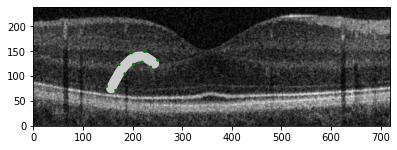

(240, 720)


In [38]:
# Test of the edge points method

# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)

t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9]
print(t_range)

drawing = Drawing(image)
drawing.add_worms(worm)
#drawing.add_dots(coords, radius=2, color='green')
drawing.add_dots(worm.edge_points(5), radius=2, color='green')

drawing.show(save='bezier.png')


print(image.shape)
# reversed as [y, x]

In [39]:
# Sort the list according to the scoring function.
# Also returns min, max and average of each score and sub-score for testing

def get_fittest(image, clew: list[Camo_Worm], w_internal: float=1.0, w_group: float=1.0, w_environment: float=1.0):
    scores = [get_cost(image, i, clew, w_internal, w_group, w_environment) for i, worm in enumerate(clew)]
    costs = [score[0] for score in scores]
    internal_scores = [score[1] for score in scores]
    group_scores = [score[2] for score in scores]
    enviro_scores = [score[3] for score in scores]
    sorted_clew = sorted(zip(clew, costs), key=lambda x: x[1])

    return (    
        [worm for worm,cost in sorted_clew],
        [np.min(costs), np.mean(costs), np.max(costs)],
        [np.min(internal_scores), np.mean(internal_scores), np.max(internal_scores)],
        [np.min(group_scores), np.mean(group_scores), np.max(group_scores)],
        [np.min(enviro_scores), np.mean(enviro_scores), np.max(enviro_scores)],
    )

# Sorted Version

This is the main loop for the SSGA.
It only sorts once at the start, then places each subsequent new worm where it should fall based on this sort.

--------HYPER_PARAMETERS--------
GENERATIONS: 5000
 POPULATION: 250
 PERCENT: 10
 
--------Generation 0, len=250, ave=0.959------------


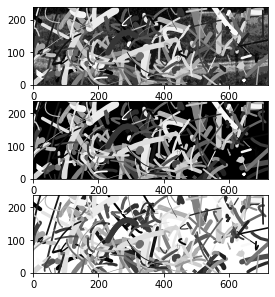

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.109 |   0.0  |  0.048  | 0.06 
1 | 0.105 |   0.0  |  0.032  | 0.073 
2 | 0.131 |   0.0  |  0.072  | 0.059 
3 | 0.111 |   0.0  |  0.016  | 0.094 
4 | 0.129 |   0.0  |  0.032  | 0.097 
--------Generation 1000, len=250, ave=0.178------------


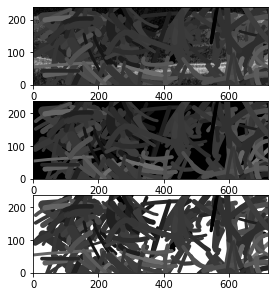

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.277 |   0.0  |  0.217  | 0.06 
1 | 0.094 |   0.0  |  0.04  | 0.054 
2 | 0.158 |   0.0  |  0.096  | 0.062 
3 | 0.113 |   0.0  |  0.048  | 0.065 
4 | 0.135 |   0.0  |  0.064  | 0.071 
--------Generation 2000, len=250, ave=0.124------------


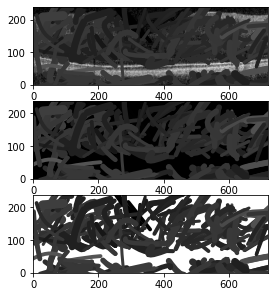

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.213 |   0.0  |  0.153  | 0.06 
1 | 0.118 |   0.0  |  0.064  | 0.054 
2 | 0.082 |   0.0  |  0.04  | 0.041 
3 | 0.085 |   0.0  |  0.04  | 0.045 
4 | 0.095 |   0.0  |  0.048  | 0.047 
--------Generation 3000, len=250, ave=0.099------------


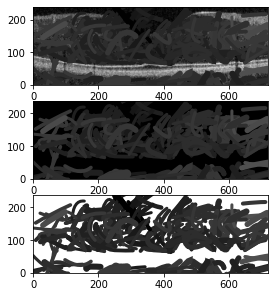

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.213 |   0.0  |  0.153  | 0.06 
1 | 0.085 |   0.0  |  0.04  | 0.045 
2 | 0.101 |   0.0  |  0.056  | 0.045 
3 | 0.086 |   0.0  |  0.032  | 0.054 
4 | 0.09 |   0.0  |  0.048  | 0.041 
--------Generation 4000, len=250, ave=0.089------------


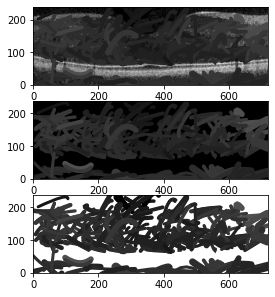

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.205 |   0.0  |  0.145  | 0.06 
1 | 0.075 |   0.0  |  0.032  | 0.043 
2 | 0.085 |   0.0  |  0.04  | 0.045 
3 | 0.069 |   0.0  |  0.024  | 0.045 
4 | 0.078 |   0.0  |  0.024  | 0.054 
--------Generation 5000, len=250, ave=0.08------------


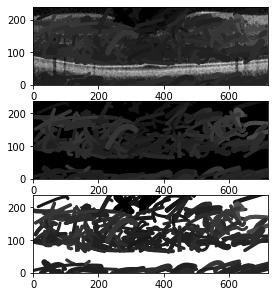

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.141 |   0.0  |  0.08  | 0.06 
1 | 0.067 |   0.0  |  0.024  | 0.043 
2 | 0.077 |   0.0  |  0.032  | 0.045 
3 | 0.064 |   0.0  |  0.016  | 0.048 
4 | 0.072 |   0.0  |  0.024  | 0.048 


In [40]:
w_internal=1.0
w_group=2.0
w_environment=1.0

# A special worm object which contains the score
class Scored_Worm:
    def __init__(self, worm, score):
        self.worm = worm
        self.score = score

# A fast function to insert a pre-scored worm at the correct position
# Taken from https://www.geeksforgeeks.org/python-program-to-insert-an-element-into-sorted-list/
def insert_sorted(sorted_clew, scored_worm):
    #print("try to add worm")
    i = len(sorted_clew) - 1 # start at end
    while(True):
        if(sorted_clew[i].score > scored_worm.score and i > 0):
            i = i - 1
        else:
            break
    
    i = i+1 # The loops goes one more than it should

    sorted_clew.insert(i, scored_worm)

# Convert the clew containing Scored_Worms into a normal Clew for use with other functions
def convert_clew(sorted_clew):
    # Convert to normal worm objects
    normal_clew = []
    for scored_worm in sorted_clew:
        worm = scored_worm.worm # get the normal object out
        normal_clew.append(worm)
    return normal_clew


# Initial Sort!!!
# sort in order with a scoring function
clew, ave_scores, ave_int, ave_gro, ave_env = get_fittest(image, clew)


# Convert to sorted list
sorted_clew = []
for worm in clew:
    worm_cost = get_cost_worm(image, worm, clew, w_internal, w_group, w_environment)[0]
    new_sorted_worm = Scored_Worm(worm, worm_cost)
    sorted_clew.append(new_sorted_worm)


print("--------HYPER_PARAMETERS--------")
print("GENERATIONS: {}\n POPULATION: {}\n PERCENT: {}\n ".format(GENERATIONS, POPULATION, PERCENT))


# 5 Updates
Update_Total = 0.2*GENERATIONS
to_file_interval = 0.002*GENERATIONS

f = open("mask4.txt", "w")
# hardcode 10 generations
for gen in range(GENERATIONS+1):

    # update the clew
    normal_clew = convert_clew(sorted_clew)

    # Every 10 generations, give summary
    if(gen % Update_Total == 0):

        scores = []
        for scored_worm in sorted_clew:
            scores.append(scored_worm.score)
        scores_ave = round(np.mean(scores), 3)

        print("--------Generation {}, len={}, ave={}------------".format(
            gen,
            len(sorted_clew),
            scores_ave
            )
        )

        drawing = Double_Drawing(image)
        # drawing = Drawing(image)
        drawing.add_worms(normal_clew)

        best_worm = normal_clew[0]
        drawing.add_worms(best_worm) # put it on top

        drawing.show()


        # Test of first 5 values
        print("Test first 5 vals")
        print("i | Score | Internal | Group | Environment")
        for i in range(5):
            scores = get_cost(image, i, normal_clew, w_internal, w_group, w_environment)
            #print("Worm {}: {}".format(i,scores[0]))
            print("{i_p} | {score} |   {int}  |  {gro}  | {env} ".format(
                i_p=i,
                score=  round(scores[0], 3),
                int=    round(scores[1], 3),
                gro=    round(scores[2], 3),
                env=    round(scores[3], 3)
            ))

    # SELECT PARENTS:

    rand1 = rng.integers(0, POPULATION)
    parent1 = sorted_clew[rand1].worm

    rand2 = rng.integers(0, POPULATION)
    parent2 = sorted_clew[rand2].worm

    # Create a new offspring
    child1_worm = parent1.mate(parent2, image)
    child1_score = get_cost_worm(image, child1_worm, normal_clew, w_internal, w_group, w_environment)[0]
    child1 = Scored_Worm(child1_worm, child1_score)

    # Get worst member to compare. List is already sorted
    worst_member_score = sorted_clew[POPULATION - 1].score
    #print("Child score:{}".format(child1_score))
    #print("Worst member score:{}".format(worst_member_score))

    # If the new worm is better, add it at the correct slot and kill the worst worm
    if( child1_score < worst_member_score):
        sorted_clew.pop() # Remove worst worm
        insert_sorted(sorted_clew, child1)
    
f.close()    

&copy; Cara MacNish, UWA, 2024